In [11]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import *


In [2]:
model_name = 'efficientnet'

cifar100_model_train = np.load(f'./data/CIFAR100_{model_name}_train_feat.npy')
cifar100_model_test = np.load(f'./data/CIFAR100_{model_name}_test_feat.npy')
print(cifar100_model_train.shape, cifar100_model_test.shape)

cifar100_vanilla_train = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_train.npy')
cifar100_vanilla_test = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_test.npy')
print(cifar100_vanilla_train.shape, cifar100_vanilla_test.shape)

cifar100_injected_train = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_train.npy')
cifar100_injected_test = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_test.npy')
print(cifar100_injected_train.shape, cifar100_injected_test.shape)

cifar100_adapted_train = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_train.npy')
cifar100_adapted_test = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_test.npy')
print(cifar100_adapted_train.shape, cifar100_adapted_test.shape)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()


(50000, 1280) (10000, 1280)
(50000, 1280) (10000, 1280)
(50000, 1280) (10000, 1280)
(50000, 1280) (10000, 1280)


In [3]:
input_shape = (cifar100_model_train.shape[1],)
batch_size = 128
epochs = 100
val_split=0.2
lr = 1e-4
callbacks = [
    #ReduceLROnPlateau(patience=5, factor=0.1),
    EarlyStopping(monitor='loss', patience=5)
]



In [4]:
%%time

model = Sequential( [
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(100, activation='softmax')
], name=model_name)

model.compile(
    optimizer=Adam(lr=lr),  
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#model.summary()

model_hist = model.fit(
    x=cifar100_model_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

model_eval = model.evaluate(
    x=cifar100_model_test,
    y=test_labels,
    batch_size=batch_size
)

print(f'{model.name} test - loss: {model_eval[0]}, accuracy: {model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 7s 20ms/step - loss: 4.7886 - accuracy: 0.0298 - val_loss: 4.1700 - val_accuracy: 0.0918
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 3.9434 - accuracy: 0.1255 - val_loss: 3.7677 - val_accuracy: 0.1443
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 3.5900 - accuracy: 0.1790 - val_loss: 3.5685 - val_accuracy: 0.1773
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 3.3862 - accuracy: 0.2121 - val_loss: 3.4185 - val_accuracy: 0.1981
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 3.2247 - accuracy: 0.2391 - val_loss: 3.3132 - val_accuracy: 0.2170
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 3.1093 - accuracy: 0.2585 - val_loss: 3.2367 - val_accuracy: 0.2291
Epoch 7/100
313/313 [==============================] - 6s 18ms/step - loss: 2.9936 - accuracy: 0.2770 - val_loss: 3.1900 - val_accuracy:

313/313 [==============================] - 6s 18ms/step - loss: 1.5302 - accuracy: 0.6007 - val_loss: 3.3472 - val_accuracy: 0.2731
Epoch 58/100
313/313 [==============================] - 6s 18ms/step - loss: 1.5425 - accuracy: 0.6000 - val_loss: 3.3632 - val_accuracy: 0.2695
Epoch 59/100
313/313 [==============================] - 6s 18ms/step - loss: 1.5192 - accuracy: 0.6054 - val_loss: 3.3668 - val_accuracy: 0.2731
Epoch 60/100
313/313 [==============================] - 6s 18ms/step - loss: 1.5131 - accuracy: 0.6065 - val_loss: 3.4481 - val_accuracy: 0.2696
Epoch 61/100
313/313 [==============================] - 5s 17ms/step - loss: 1.4851 - accuracy: 0.6108 - val_loss: 3.3873 - val_accuracy: 0.2749
Epoch 62/100
313/313 [==============================] - 5s 18ms/step - loss: 1.4723 - accuracy: 0.6155 - val_loss: 3.4444 - val_accuracy: 0.2737
Epoch 63/100
313/313 [==============================] - 5s 17ms/step - loss: 1.4676 - accuracy: 0.6191 - val_loss: 3.4281 - val_accuracy: 0.268

In [5]:
%%time

vanilla_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(100, activation='softmax')
], name='vanilla')

vanilla_model.compile(
    optimizer=Adam(lr=lr),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#vanilla_model.summary()

vanilla_hist = vanilla_model.fit(
    x=cifar100_vanilla_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

vanilla_model_eval = vanilla_model.evaluate(
    x=cifar100_vanilla_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{vanilla_model.name} test - loss: {vanilla_model_eval[0]}, accuracy: {vanilla_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 5.1134 - accuracy: 0.0108 - val_loss: 4.9800 - val_accuracy: 0.0108
Epoch 2/100
313/313 [==============================] - 5s 18ms/step - loss: 4.8429 - accuracy: 0.0176 - val_loss: 4.9103 - val_accuracy: 0.0134
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 4.6373 - accuracy: 0.0259 - val_loss: 4.8376 - val_accuracy: 0.0166
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 4.4891 - accuracy: 0.0396 - val_loss: 4.7819 - val_accuracy: 0.0203
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 4.3547 - accuracy: 0.0516 - val_loss: 4.7435 - val_accuracy: 0.0218
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 4.2467 - accuracy: 0.0645 - val_loss: 4.7185 - val_accuracy: 0.0233
Epoch 7/100
313/313 [==============================] - 6s 19ms/step - loss: 4.1378 - accuracy: 0.0793 - val_loss: 4.7025 - val_accuracy:

313/313 [==============================] - 6s 18ms/step - loss: 1.3350 - accuracy: 0.6877 - val_loss: 7.3994 - val_accuracy: 0.0242
Epoch 58/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3135 - accuracy: 0.6885 - val_loss: 7.4737 - val_accuracy: 0.0242
Epoch 59/100
313/313 [==============================] - 5s 18ms/step - loss: 1.2803 - accuracy: 0.7044 - val_loss: 7.5502 - val_accuracy: 0.0243
Epoch 60/100
313/313 [==============================] - 5s 17ms/step - loss: 1.2414 - accuracy: 0.7121 - val_loss: 7.6323 - val_accuracy: 0.0236
Epoch 61/100
313/313 [==============================] - 6s 18ms/step - loss: 1.2193 - accuracy: 0.7167 - val_loss: 7.7185 - val_accuracy: 0.0232
Epoch 62/100
313/313 [==============================] - 5s 17ms/step - loss: 1.1828 - accuracy: 0.7257 - val_loss: 7.7952 - val_accuracy: 0.0240
Epoch 63/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1668 - accuracy: 0.7292 - val_loss: 7.8786 - val_accuracy: 0.023

In [6]:
%%time

injected_model = tf.keras.Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='softmax')
], name='injected')

injected_model.compile(
    optimizer=Adam(lr=lr),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#injected_model.summary()

injected_hist = injected_model.fit(
    x=cifar100_injected_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

injected_model_eval = injected_model.evaluate(
    x=cifar100_injected_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{injected_model.name} test - loss: {injected_model_eval[0]}, accuracy: {injected_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 6s 18ms/step - loss: 5.1149 - accuracy: 0.0099 - val_loss: 4.9726 - val_accuracy: 0.0122
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 4.8249 - accuracy: 0.0166 - val_loss: 4.8849 - val_accuracy: 0.0152
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 4.6178 - accuracy: 0.0278 - val_loss: 4.7944 - val_accuracy: 0.0180
Epoch 4/100
313/313 [==============================] - 6s 18ms/step - loss: 4.4475 - accuracy: 0.0416 - val_loss: 4.7250 - val_accuracy: 0.0228
Epoch 5/100
313/313 [==============================] - 6s 18ms/step - loss: 4.3018 - accuracy: 0.0565 - val_loss: 4.6755 - val_accuracy: 0.0260
Epoch 6/100
313/313 [==============================] - 6s 18ms/step - loss: 4.1927 - accuracy: 0.0727 - val_loss: 4.6423 - val_accuracy: 0.0293
Epoch 7/100
313/313 [==============================] - 5s 18ms/step - loss: 4.0971 - accuracy: 0.0863 - val_loss: 4.6197 - val_accuracy:

313/313 [==============================] - 6s 18ms/step - loss: 1.3600 - accuracy: 0.6784 - val_loss: 7.0841 - val_accuracy: 0.0288
Epoch 58/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3352 - accuracy: 0.6852 - val_loss: 7.1558 - val_accuracy: 0.0285
Epoch 59/100
313/313 [==============================] - 6s 18ms/step - loss: 1.3130 - accuracy: 0.6885 - val_loss: 7.2283 - val_accuracy: 0.0283
Epoch 60/100
313/313 [==============================] - 5s 17ms/step - loss: 1.2716 - accuracy: 0.6999 - val_loss: 7.3043 - val_accuracy: 0.0286
Epoch 61/100
313/313 [==============================] - 5s 17ms/step - loss: 1.2430 - accuracy: 0.7071 - val_loss: 7.3821 - val_accuracy: 0.0274
Epoch 62/100
313/313 [==============================] - 5s 18ms/step - loss: 1.2191 - accuracy: 0.7130 - val_loss: 7.4582 - val_accuracy: 0.0281
Epoch 63/100
313/313 [==============================] - 6s 18ms/step - loss: 1.1912 - accuracy: 0.7235 - val_loss: 7.5317 - val_accuracy: 0.026

In [7]:
%%time

adapted_model = Sequential([
    Input(shape=input_shape),
    Dense(128, activation='relu'),
    BatchNormalization(),
    
    Dense(128, activation='relu'),
    BatchNormalization(),

    Dense(100, activation='softmax')
],name='adapted' )

adapted_model.compile(
    optimizer=Adam(lr=lr),             
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#adapted_model.summary()

adapted_hist = adapted_model.fit(
    x=cifar100_adapted_train, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=val_split,
    callbacks=callbacks
)

adapted_model_eval = adapted_model.evaluate(
    x=cifar100_adapted_test, 
    y=test_labels,
    batch_size=batch_size
)

print(f'{adapted_model.name} test - loss: {adapted_model_eval[0]}, accuracy: {adapted_model_eval[1]}')

Epoch 1/100
313/313 [==============================] - 5s 13ms/step - loss: 5.1359 - accuracy: 0.0104 - val_loss: 5.0160 - val_accuracy: 0.0107
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 4.8879 - accuracy: 0.0142 - val_loss: 4.9700 - val_accuracy: 0.0109
Epoch 3/100
313/313 [==============================] - 4s 12ms/step - loss: 4.7141 - accuracy: 0.0213 - val_loss: 4.9224 - val_accuracy: 0.0119
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 4.5739 - accuracy: 0.0292 - val_loss: 4.8878 - val_accuracy: 0.0124
Epoch 5/100
313/313 [==============================] - 4s 13ms/step - loss: 4.4570 - accuracy: 0.0389 - val_loss: 4.8646 - val_accuracy: 0.0139
Epoch 6/100
313/313 [==============================] - 4s 12ms/step - loss: 4.3598 - accuracy: 0.0489 - val_loss: 4.8494 - val_accuracy: 0.0144
Epoch 7/100
313/313 [==============================] - 4s 13ms/step - loss: 4.2698 - accuracy: 0.0620 - val_loss: 4.8399 - val_accuracy:

Epoch 58/100
313/313 [==============================] - 3s 8ms/step - loss: 1.4408 - accuracy: 0.6598 - val_loss: 7.5675 - val_accuracy: 0.0134
Epoch 59/100
313/313 [==============================] - 3s 8ms/step - loss: 1.4180 - accuracy: 0.6637 - val_loss: 7.6444 - val_accuracy: 0.0131
Epoch 60/100
313/313 [==============================] - 3s 8ms/step - loss: 1.3696 - accuracy: 0.6775 - val_loss: 7.7244 - val_accuracy: 0.0132
Epoch 61/100
313/313 [==============================] - 3s 8ms/step - loss: 1.3512 - accuracy: 0.6823 - val_loss: 7.8088 - val_accuracy: 0.0128
Epoch 62/100
313/313 [==============================] - 3s 8ms/step - loss: 1.3261 - accuracy: 0.6890 - val_loss: 7.8804 - val_accuracy: 0.0131
Epoch 63/100
313/313 [==============================] - 3s 8ms/step - loss: 1.2804 - accuracy: 0.6985 - val_loss: 7.9648 - val_accuracy: 0.0129
Epoch 64/100
313/313 [==============================] - 2s 6ms/step - loss: 1.2582 - accuracy: 0.7040 - val_loss: 8.0387 - val_accuracy:

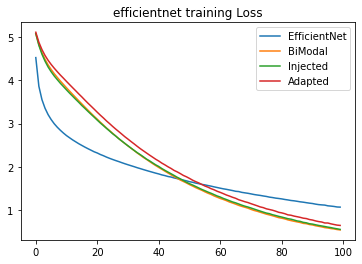

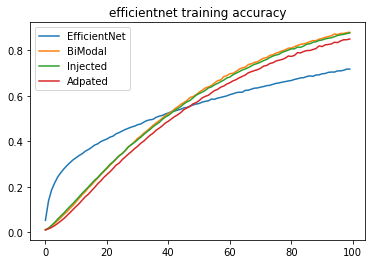

In [17]:
metric = 'accuracy'
plt.plot(model_hist.history['loss'], label=f'EfficientNet')
plt.plot(vanilla_hist.history['loss'], label='BiModal')
plt.plot(injected_hist.history['loss'], label='Injected')
plt.plot(adapted_hist.history['loss'], label='Adapted')
plt.legend()
plt.title(f'{model_name } training Loss')
plt.savefig(f'./plots/{model_name}/loss.png')
plt.show()

plt.plot(model_hist.history[f'{metric}'], label=f'EfficientNet')
plt.plot(vanilla_hist.history[f'{metric}'], label='BiModal')
plt.plot(injected_hist.history[f'{metric}'], label='Injected')
plt.plot(adapted_hist.history[f'{metric}'], label='Adpated')
plt.legend()
plt.title(f'{model_name} training accuracy')
plt.savefig(f'./plots/{model_name}/accuracy.png')
plt.show()

In [15]:
test_data = {
    'model': [f'{model_name}', f'{model_name}_vanilla', f'{model_name}_injected', f'{model_name}_adapted'],
    f'loss': [model_eval[0], vanilla_model_eval[0], injected_model_eval[0], adapted_model_eval[0]],
    f'acc': [model_eval[1], vanilla_model_eval[1], injected_model_eval[1], adapted_model_eval[1]]
}

test_df = pd.DataFrame(data=test_data)

  
test_df.to_csv(f'results/{model_name}_test_df.csv') 

test_df.head()

,model,loss,acc
0,efficientnet,4.024677,0.2679
1,efficientnet_vanilla,10.909360,0.0206
2,efficientnet_injected,10.460599,0.0269
3,efficientnet_adapted,10.948413,0.0160
